# Preface

In this notebook you will find a very thorough EDA of the given music database, followed by the use of several models (mainly SVM) to predict music genres.

The notebook is divided into 5 parts. Those who wish to skip a certain part can **jump to the end** of that part where you'll **find a summary** of that section.

**1. Data Exploration:** here we go through the features one by one, determine their usefulness, and clean them for future use.

**2. Final Preprocessing:** normalizing, removing outliers, train-test splitting etc.

**3. Modeling:** here we use a few simple models on the train set and examine the results. Spoiler alert, they're not good.

**4. Consolidating Classes:** here you'll find an attempt to improve the model's prediction ability by consolidating appropriate genres.

**5. Final Test Results:** what it says on the tin.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import zscore
import fasttext
import os
%matplotlib inline

In [2]:
# read the data
data = pd.read_csv('../input/prediction-of-music-genre/music_genre.csv')

# 1. Data Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [4]:
data[data.isnull().any(axis=1)]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### There are only 5 rows that contain NaN values. We'll remove them:

In [5]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [6]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [7]:
data.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [8]:
data.describe(include=['O'])

,artist_name,track_name,key,mode,tempo,obtained_date,music_genre
count,50000,50000,50000,50000,50000,50000,50000
unique,6863,41699,12,2,29394,5,10
top,empty_field,Home,G,Major,?,4-Apr,Electronic
freq,2489,16,5727,32099,4980,44748,5000


#### We can see that there are 17 features and one label column (music_genre). Out of the features, 12 are numerical (one of which, tempo, is missclassified and will be dealt with later), and 5 are categorical.

#### We can also already see hints to hidden missing values in 3 features ('tempo', 'artist_name' and 'duration_ms'). Those will be dealt with shortly one by one.

In [9]:
# check if the data is balanced
data['music_genre'].value_counts()

Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: music_genre, dtype: int64

#### There are 10 different genres with equal distribution (balanced data). This means the accuracy score will be a good metric to use.

## Exploring the features one by one:

## Instance_id:

#### This is just an index. We'll drop it.

In [10]:
data = data.drop(columns=['instance_id'])

## Artist's Names:

In [11]:
print(f"There are {data['artist_name'].nunique()} unique artists in the set")

There are 6863 unique artists in the set


In [12]:
data['artist_name'].describe()

count           50000
unique           6863
top       empty_field
freq             2489
Name: artist_name, dtype: object

In [13]:
missing_artist = data[data['artist_name'] == 'empty_field']
missing_artist.head()

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
19,empty_field,7th Sevens,50.0,0.0281,0.656,307328.0,0.653,0.858000,F#,0.1120,-11.883,Minor,0.0396,117.999,4-Apr,0.199,Electronic
25,empty_field,Revolution,34.0,0.0236,0.715,221050.0,0.978,0.000493,D,0.2160,-1.538,Major,0.3620,125.109,4-Apr,0.418,Electronic
44,empty_field,World (The Price Of Love) - [Radio Edit] [2015...,31.0,0.0035,0.595,222147.0,0.904,0.003780,D,0.0533,-6.805,Minor,0.0349,127.61,4-Apr,0.841,Electronic
128,empty_field,Down With Me - VIP,32.0,0.0139,0.498,-1.0,0.945,0.647000,F,0.3380,-0.003,Minor,0.1370,149.888,4-Apr,0.179,Electronic
135,empty_field,Olvidela Compa,44.0,0.1530,0.792,265133.0,0.549,0.379000,F,0.3430,-9.855,Major,0.0456,120.01299999999999,4-Apr,0.476,Electronic


In [14]:
print(f"Percent of missing artist names: {(missing_artist.shape[0]/data.shape[0])*100:2.4}%")

Percent of missing artist names: 4.978%


#### 5% of the observations are missing the artist's names (marked as 'empty_field'), but these entries are still valid otherwise. we will not drop these observations.

In [15]:
data[data['artist_name'] != 'empty_field'].groupby('artist_name')['music_genre'].nunique().value_counts(normalize=True)

1    0.799767
2    0.171087
3    0.027834
4    0.001312
Name: music_genre, dtype: float64

#### For the entries that do contain an artist's name, it seems that a song that comes from a particular artist has an ~80% chance of belonging to one specific genre.
#### However, in it's current form it's not helpful for classifying songs from artists outside the training set. We'll need to extract more general features, starting with the simplest - name length.

In [16]:
# find the length of the artists names
data['length_name'] = data['artist_name'].str.len()

In [17]:
data[data['artist_name'] != 'empty_field'].groupby('music_genre')['length_name'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,4728.0,11.397631,4.898169,1.0,8.0,11.0,14.0,46.0
Anime,4728.0,12.198604,5.419303,2.0,8.0,12.0,15.0,35.0
Blues,4745.0,13.544573,5.425815,1.0,10.0,12.0,16.0,40.0
Classical,4734.0,16.336502,4.489369,4.0,13.0,15.0,20.0,52.0
Country,4779.0,12.656623,3.277890,3.0,11.0,12.0,14.0,41.0
Electronic,4777.0,9.734561,4.199621,2.0,7.0,9.0,12.0,26.0
Hip-Hop,4755.0,9.376025,3.986559,2.0,6.0,9.0,12.0,36.0
Jazz,4770.0,12.504193,4.777946,3.0,10.0,12.0,15.0,51.0
Rap,4737.0,9.645134,4.028050,2.0,7.0,9.0,12.0,38.0


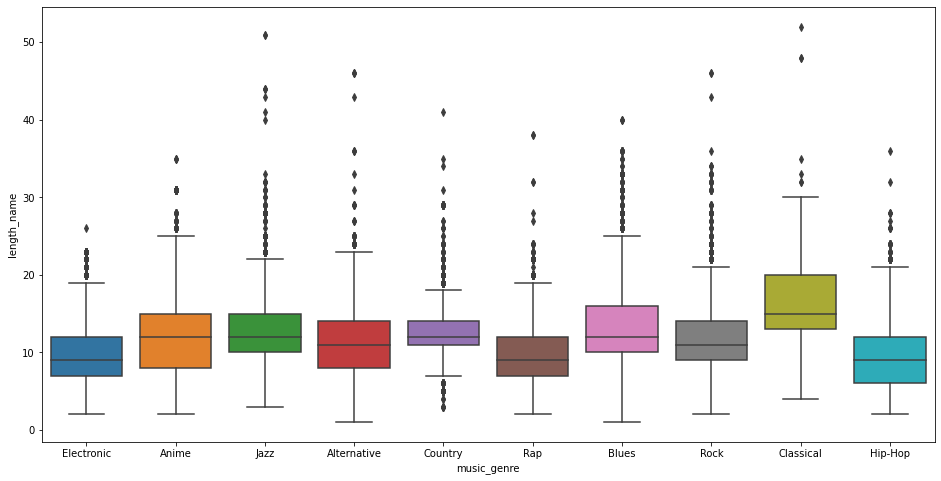

In [18]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data[data['artist_name'] != 'empty_field'], x='music_genre', y='length_name')
plt.show()

#### From the above statistics it seems that classical music tends to have noticeably longer names. Could potentialy be a useful feature. We'll keep it in for now.

## Track names:

In [19]:
data['track_name'].describe()

count     50000
unique    41699
top        Home
freq         16
Name: track_name, dtype: object

In [20]:
# generate track name length
data['length_track_name'] = data['track_name'].str.len()

In [21]:
data.groupby('music_genre')['length_track_name'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,14.9672,10.213549,1.0,9.0,13.0,18.0,127.0
Anime,5000.0,15.4680,12.620746,1.0,7.0,12.0,19.0,112.0
Blues,5000.0,19.9576,13.233111,1.0,12.0,17.0,24.0,119.0
Classical,5000.0,48.2104,27.889749,3.0,26.0,47.0,65.0,250.0
Country,5000.0,18.7490,11.491441,1.0,11.0,16.0,23.0,116.0
Electronic,5000.0,17.1644,11.713053,1.0,8.0,13.0,23.0,125.0
Hip-Hop,5000.0,16.4510,12.525613,1.0,8.0,12.0,21.0,139.0
Jazz,5000.0,18.0034,12.456967,1.0,10.0,15.0,22.0,142.0
Rap,5000.0,16.2834,11.908528,1.0,8.0,13.0,21.0,139.0


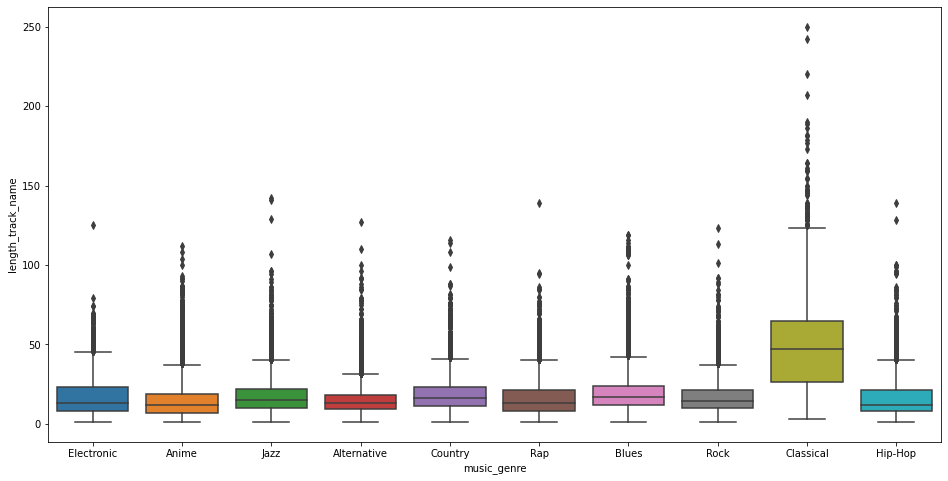

In [22]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='length_track_name')
plt.show()

#### The classical genre also has longer track names. The difference is much more pronounced than for the artist's name. This is a better feature for us to use, since it doesn't have the missing values problem. We'll use this and not the artist name length feature.

In [23]:
# drop 'length_name' feature
data = data.drop(columns = ['length_name'])

#### Next we'll make a feature out off the sample's language. Specifically, whether it's written in Japanese. This may help us identify the Anime genre, which is likely to contain track/artist names written in the Japanese alphabet, as shown below:

In [24]:
data[data['music_genre'] == 'Anime'].head()

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,length_track_name
5000,Capcom Sound Team,終幕組曲【冒險の終わり】,11.0,0.01540,0.362,429560.0,0.456,0.024100,D,0.2580,-11.355,Minor,0.0376,117.634,4-Apr,0.332,Anime,12
5001,ayaka,そこまで歩いていくよ,26.0,0.82000,0.627,-1.0,0.350,0.000000,G,0.1250,-7.951,Major,0.0291,135.937,4-Apr,0.173,Anime,10
5002,Hachioji P,KiLLER LADY - Eight Mix,29.0,0.00857,0.643,234874.0,0.966,0.003310,A#,0.2550,-3.902,Minor,0.0442,131.982,4-Apr,0.912,Anime,23
5003,LiSA,Bad Sweet Trap,18.0,0.00711,0.585,229147.0,0.991,0.000002,F,0.1100,-2.817,Minor,0.1170,?,4-Apr,0.580,Anime,14
5004,Hiroyuki Sawano,Call Your Name,50.0,0.01450,0.567,268333.0,0.300,0.000000,B,0.0687,-8.421,Minor,0.0291,141.819,4-Apr,0.196,Anime,14


In [25]:
# download pretrained language identification model
os.system(f"wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz")

--2022-01-11 18:39:14--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

     0K .......... .......... .......... .......... ..........  5%  285K 3s
    50K .......... .......... .......... .......... .......... 10%  265K 3s
   100K .......... .......... .......... .......... .......... 16%  279K 3s
   150K .......... .......... .......... .......... .......... 21%  112M 2s
   200K .......... .......... .......... .......... .......... 27% 13.7M 1s
   250K .......... .......... .......... .......... .......... 32%  271K 2s
   300K .......... .......... .......... .......... .......... 38%  117M 1s
   350K .......... .......... .......... .......... ..

0

In [26]:
PRETRAINED_MODEL_PATH = 'lid.176.ftz'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [27]:
def find_japanese(df):
    '''
    returns a 1D-array of 0's ans 1's, as well as the confidence of each prediction.
    1 - if either the artist or track name is written in japanese.
    0 - otherwise
    ''' 
    jap = []
    confidence = []
    
    for _, row in df.iterrows():      
        pred_track, confidence_track = model.predict(row['track_name'])
        pred_track = pred_track[0].split('__')[-1]
        pred_artist, confidence_artist = model.predict(row['artist_name'])
        pred_artist = pred_artist[0].split('__')[-1]

        # check the confidence of the language detection
        if (pred_track == 'ja') or (pred_artist == 'ja'):
            jap.append(1)
            confidence.append(np.max([confidence_track[0], confidence_artist[0]]))
        else:
            jap.append(0)
    
    return jap, np.array(confidence)
            

In [28]:
data['Japanese'], confidence = find_japanese(data[['artist_name', 'track_name']])

In [29]:
print(f"The average confidence level for the japanese predictions is {confidence.mean():1.2} +\- {confidence.std():1.2}")

The average confidence level for the japanese predictions is 0.9 +\- 0.17


The model has a high confidence level for Japanese/non-Japanese predictions, likely due to the unique alphabet.

In [30]:
data.groupby('music_genre')['Japanese'].value_counts(normalize=True)

music_genre  Japanese
Alternative  0           0.9960
             1           0.0040
Anime        0           0.7900
             1           0.2100
Blues        0           0.9980
             1           0.0020
Classical    0           0.9932
             1           0.0068
Country      0           0.9996
             1           0.0004
Electronic   0           0.9980
             1           0.0020
Hip-Hop      0           0.9946
             1           0.0054
Jazz         0           0.9990
             1           0.0010
Rap          0           0.9950
             1           0.0050
Rock         0           0.9980
             1           0.0020
Name: Japanese, dtype: float64

#### More than 20% of the Anime tracks are indeed written in Japanese, a much higher percentage than all the other music genres combined. This could indeed help us identify the Anime genre.

#### After engineering new features from the artist/track names, we can drop the original features.

In [31]:
data = data.drop(columns=['artist_name', 'track_name'])

## Popularity:

In [32]:
data.groupby('music_genre')['popularity'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,50.2242,7.664260,0.0,45.00,49.0,55.0,83.0
Anime,5000.0,24.2716,9.675151,0.0,17.00,23.0,30.0,65.0
Blues,5000.0,34.8040,9.716422,0.0,28.75,33.0,39.0,80.0
Classical,5000.0,29.3158,14.100519,0.0,25.00,32.0,38.0,68.0
Country,5000.0,46.0100,9.771540,0.0,39.00,44.0,52.0,82.0
Electronic,5000.0,38.1118,9.715378,0.0,31.00,37.0,44.0,96.0
Hip-Hop,5000.0,58.3996,8.302271,18.0,52.00,57.0,63.0,96.0
Jazz,5000.0,40.9286,9.517333,0.0,36.00,40.0,46.0,79.0
Rap,5000.0,60.4974,8.160620,14.0,55.00,59.0,65.0,99.0


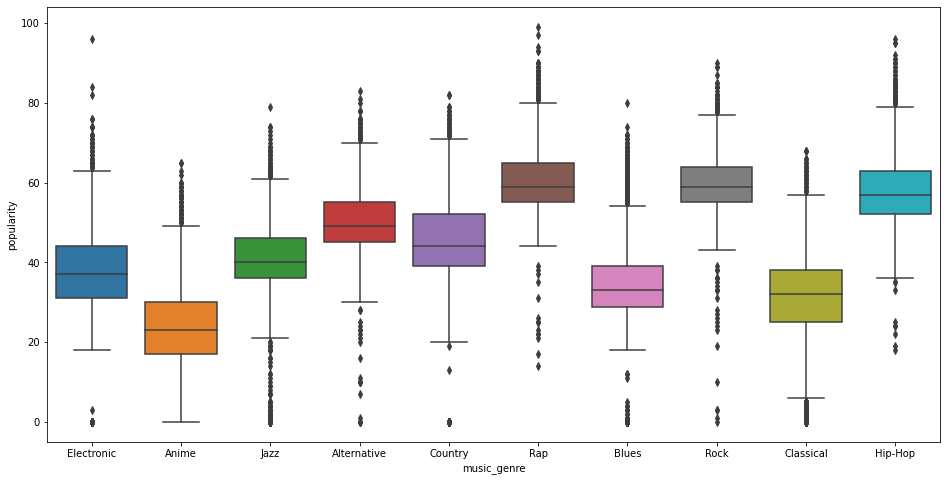

In [33]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='popularity')
plt.show()

#### This feature shows a nice spread of distributions for the different genres. Could definitely be useful for classification.
#### Rap, Hip-Hop and Rock seem to be the most popular genres, while Anime, Blues and Classical are the least popular. The other 4 genres are somewhere in between.

## acousticness:

In [34]:
data.groupby('music_genre')['acousticness'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.164983,0.242942,0.000001,0.002087,0.03360,0.24000,0.992
Anime,5000.0,0.286968,0.362371,0.000000,0.005193,0.06650,0.57600,0.996
Blues,5000.0,0.317830,0.306287,0.000002,0.037875,0.21500,0.55725,0.996
Classical,5000.0,0.869139,0.256728,0.000001,0.909000,0.96700,0.98800,0.996
Country,5000.0,0.268827,0.262072,0.000028,0.046525,0.17500,0.43425,0.981
Electronic,5000.0,0.121971,0.201634,0.000002,0.004060,0.02620,0.14000,0.985
Hip-Hop,5000.0,0.179093,0.189449,0.000015,0.033900,0.10900,0.26700,0.985
Jazz,5000.0,0.494564,0.338640,0.000002,0.153000,0.51500,0.81900,0.996
Rap,5000.0,0.169057,0.192257,0.000007,0.024675,0.09385,0.25300,0.945


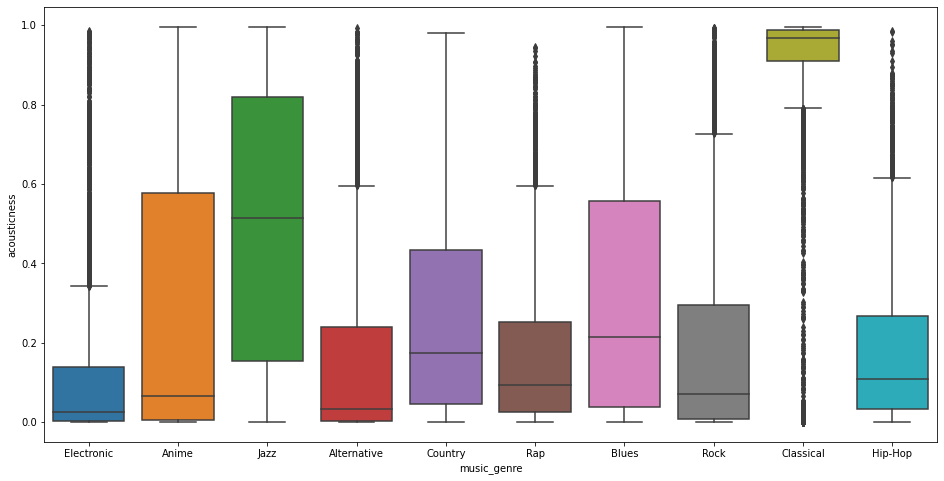

In [35]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='acousticness')
plt.show()

#### Interestingly, classical music is once again quite the outlier. (Also Jazz, to a lesser extant)

## Danceability:

In [36]:
data.groupby('music_genre')['danceability'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.541124,0.150073,0.0617,0.44100,0.539,0.64300,0.971
Anime,5000.0,0.471002,0.148760,0.0606,0.37900,0.488,0.57800,0.905
Blues,5000.0,0.529243,0.144694,0.1180,0.42600,0.529,0.63500,0.967
Classical,5000.0,0.306560,0.135138,0.0600,0.19800,0.301,0.40200,0.775
Country,5000.0,0.577316,0.108931,0.2030,0.50900,0.581,0.64725,0.953
Electronic,5000.0,0.619220,0.147034,0.0822,0.52900,0.629,0.72400,0.979
Hip-Hop,5000.0,0.717373,0.130400,0.2300,0.64000,0.733,0.81400,0.986
Jazz,5000.0,0.584736,0.159487,0.0596,0.47200,0.600,0.70500,0.976
Rap,5000.0,0.696605,0.140232,0.1970,0.60200,0.714,0.80100,0.977


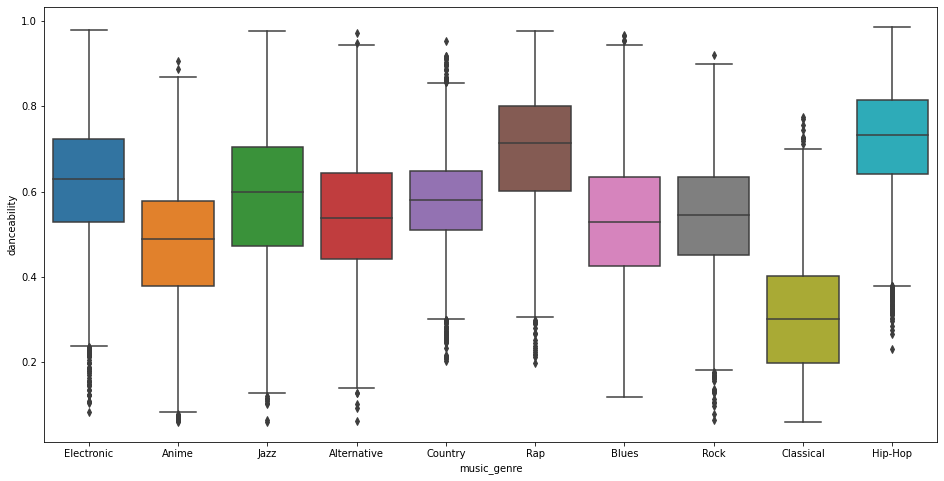

In [37]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='danceability')
plt.show()

#### Classical music sticks out again, but Rap and Hip-Hop can also be distinguished from the rest (they seem to go together often).

## Duration:

In [38]:
data.groupby('music_genre')['duration_ms'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,210404.8078,90366.002886,-1.0,185994.75,219561.5,255583.00,675653.0
Anime,5000.0,208880.8290,105275.946177,-1.0,146250.25,230205.5,272993.25,1295600.0
Blues,5000.0,229301.0962,131931.237262,-1.0,171910.00,221140.0,280033.25,2019293.0
Classical,5000.0,278014.3464,219698.722816,-1.0,148770.25,241640.0,362070.25,3195440.0
Country,5000.0,195556.0686,77252.730320,-1.0,179328.25,207073.5,233839.25,599315.0
Electronic,5000.0,244553.3832,164125.128913,-1.0,192655.50,236888.0,300000.00,4830606.0
Hip-Hop,5000.0,198395.9458,86465.775861,-1.0,167707.00,209056.0,248627.00,723573.0
Jazz,5000.0,238092.4468,133485.337615,-1.0,170491.00,236040.0,304278.50,1352413.0
Rap,5000.0,196508.7920,85618.048197,-1.0,168339.00,207509.5,244454.25,579293.0


#### -1.0 is obvously not a valid time measurement. These are missing values.

In [39]:
miss_duration = data[data['duration_ms'] == -1].shape[0]
num_obs_tot = data.shape[0]
print(f"There are {miss_duration} missing values, which accounts for {(miss_duration/num_obs_tot)*100:2.4}% of the data points.")

There are 4939 missing values, which accounts for 9.878% of the data points.


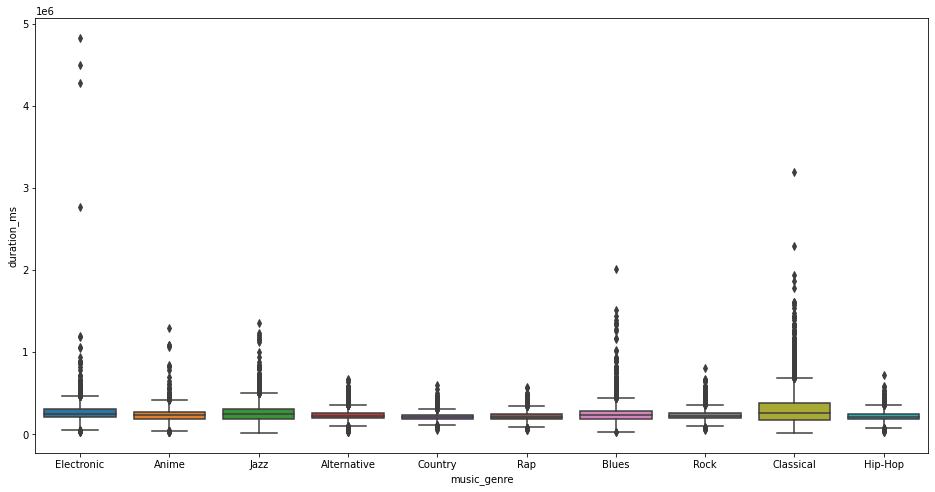

In [40]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data[data['duration_ms'] != -1], x='music_genre', y='duration_ms')
plt.show()

#### Almost 10% of the entries are missing a duration. We don't want to remove such a large amount of observations, so we'll fill in the missing values with the median, but consider removing the feature entirely in the future. 
#### Also of note is the fact that this feature contains extreme outliers. They could be important for classification, but we'll consider removing them at a later stage

In [41]:
# fill in median for missing values
mask_duration = data['duration_ms'] != -1
median_duration = data.loc[mask_duration, 'duration_ms'].median()
data.loc[~mask_duration, 'duration_ms'] = median_duration

## Energy:

In [42]:
data.groupby('music_genre')['energy'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.710880,0.206841,0.048400,0.55700,0.7470,0.89025,0.998
Anime,5000.0,0.664568,0.300289,0.000943,0.42200,0.7830,0.92500,0.999
Blues,5000.0,0.609753,0.227894,0.009570,0.44400,0.6290,0.80000,0.998
Classical,5000.0,0.176534,0.225583,0.000792,0.03660,0.1010,0.20700,0.994
Country,5000.0,0.638903,0.199112,0.021000,0.49800,0.6700,0.80400,0.991
Electronic,5000.0,0.738636,0.187862,0.021100,0.61100,0.7730,0.89700,0.999
Hip-Hop,5000.0,0.644334,0.150461,0.095200,0.54175,0.6475,0.75300,0.995
Jazz,5000.0,0.474847,0.239362,0.002110,0.28900,0.4780,0.65700,0.997
Rap,5000.0,0.651301,0.156123,0.079300,0.54275,0.6490,0.76300,0.997


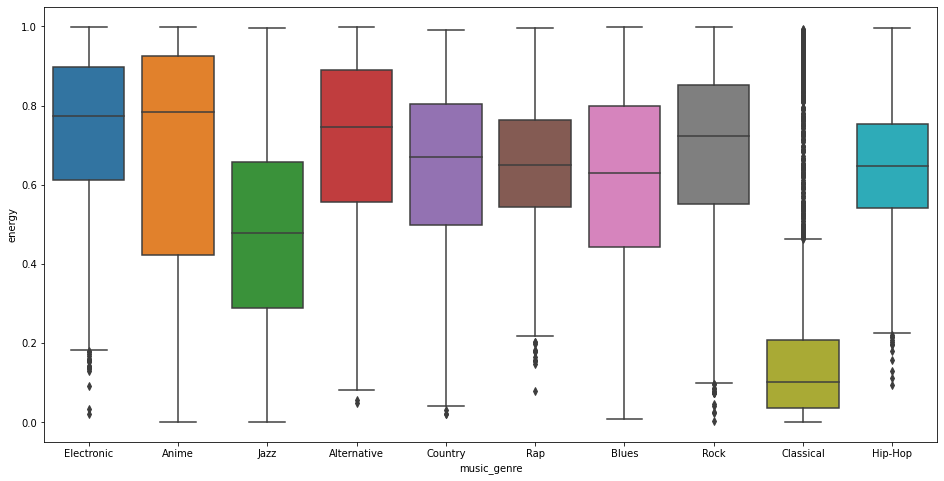

In [43]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='energy')
plt.show()

#### As usual, classical music stands out (and Jazz to a much lesser degree). Rap and Hip-Hop still match each other.

## Instrumentalness:

In [44]:
data.groupby('music_genre')['instrumentalness'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.060818,0.174351,0.0,0.00000,0.000068,0.006600,0.942
Anime,5000.0,0.278057,0.390610,0.0,0.00000,0.000400,0.768000,0.996
Blues,5000.0,0.094134,0.213205,0.0,0.00001,0.000957,0.038000,0.966
Classical,5000.0,0.600692,0.378027,0.0,0.14875,0.832000,0.905000,0.994
Country,5000.0,0.005320,0.041110,0.0,0.00000,0.000000,0.000039,0.880
Electronic,5000.0,0.348139,0.361742,0.0,0.00316,0.182000,0.749250,0.986
Hip-Hop,5000.0,0.010836,0.073129,0.0,0.00000,0.000000,0.000011,0.927
Jazz,5000.0,0.354271,0.383342,0.0,0.00017,0.120500,0.797000,0.985
Rap,5000.0,0.009084,0.065314,0.0,0.00000,0.000000,0.000010,0.922


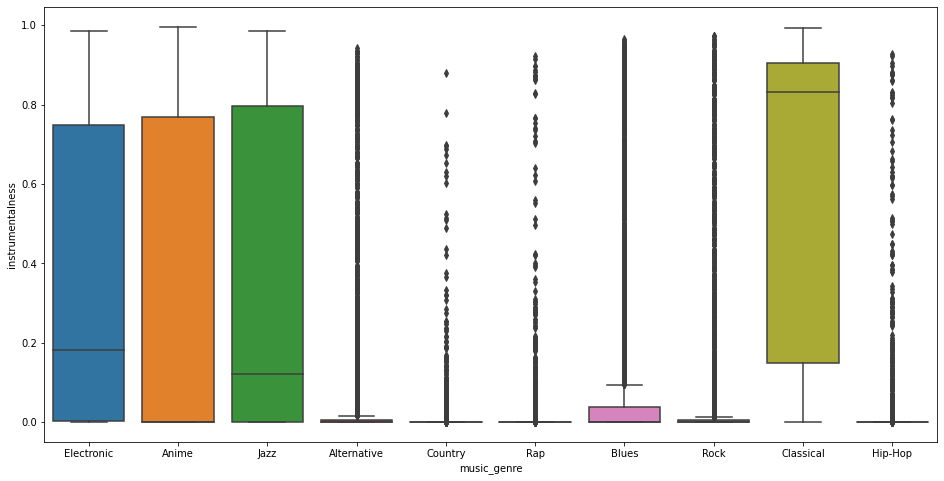

In [45]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='instrumentalness')
plt.show()

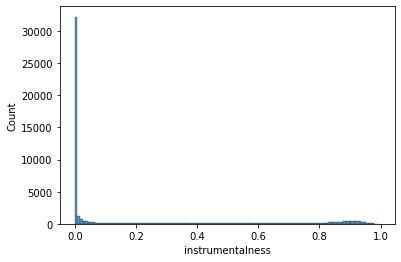

In [46]:
sns.histplot(x='instrumentalness',data=data);

In [47]:
inst_0 = data[data['instrumentalness'] == 0].shape[0]
num_obs = data.shape[0]
print(f"There are {inst_0} observations with 0.0 instrumentalness, which accounts for {(inst_0/num_obs)*100:2.4}% of the data points")

There are 15001 observations with 0.0 instrumentalness, which accounts for 30.0% of the data points


#### Such a large number of 0.0 entries likely indicates missing values rather than real data points. Since this is a 3rd of our observations, we won't fill in missing values. Instead, we'll discard this feature entirely.

In [48]:
data = data.drop(columns=['instrumentalness'])

## Key:

In [49]:
data['key'].unique()

array(['A#', 'D', 'G#', 'C#', 'F#', 'B', 'G', 'F', 'A', 'C', 'E', 'D#'],
      dtype=object)

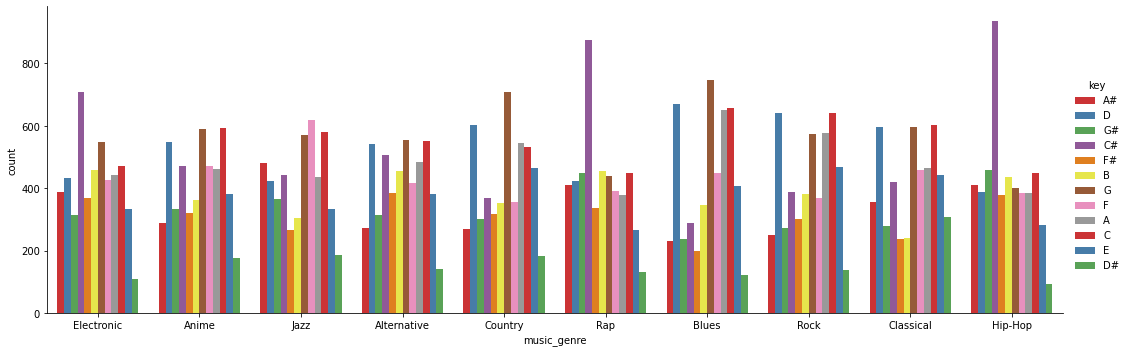

In [50]:
sns.catplot(x="music_genre", hue="key",data=data, kind="count",height=5, aspect=3.0, palette = 'Set1');

In [51]:
data.groupby('music_genre')['key'].describe()

,count,unique,top,freq
music_genre,,,,
Alternative,5000,12,G,555
Anime,5000,12,C,594
Blues,5000,12,G,747
Classical,5000,12,C,602
Country,5000,12,G,707
Electronic,5000,12,C#,709
Hip-Hop,5000,12,C#,936
Jazz,5000,12,F,619
Rap,5000,12,C#,874


#### Different genres have noticeably different spreads. We'll keep this feature, but use One Hot Encoding to make it useful.

In [52]:
# One Hot Encoding
data = pd.get_dummies(data, drop_first=True, prefix='key', columns=['key'])

## Liveness:

In [53]:
data.groupby('music_genre')['liveness'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.197119,0.156115,0.02120,0.099000,0.132,0.25600,0.996
Anime,5000.0,0.193444,0.138930,0.01690,0.098800,0.137,0.27525,0.967
Blues,5000.0,0.233206,0.220590,0.00967,0.097700,0.139,0.28600,1.000
Classical,5000.0,0.161046,0.143591,0.02250,0.088975,0.110,0.15700,0.987
Country,5000.0,0.187781,0.153594,0.02120,0.098600,0.128,0.23100,0.986
Electronic,5000.0,0.209782,0.176166,0.01730,0.095800,0.129,0.28325,0.984
Hip-Hop,5000.0,0.200870,0.153262,0.01960,0.103000,0.136,0.26200,0.989
Jazz,5000.0,0.171721,0.147107,0.01880,0.094200,0.115,0.18300,0.986
Rap,5000.0,0.198035,0.151165,0.02080,0.103000,0.135,0.25400,0.989


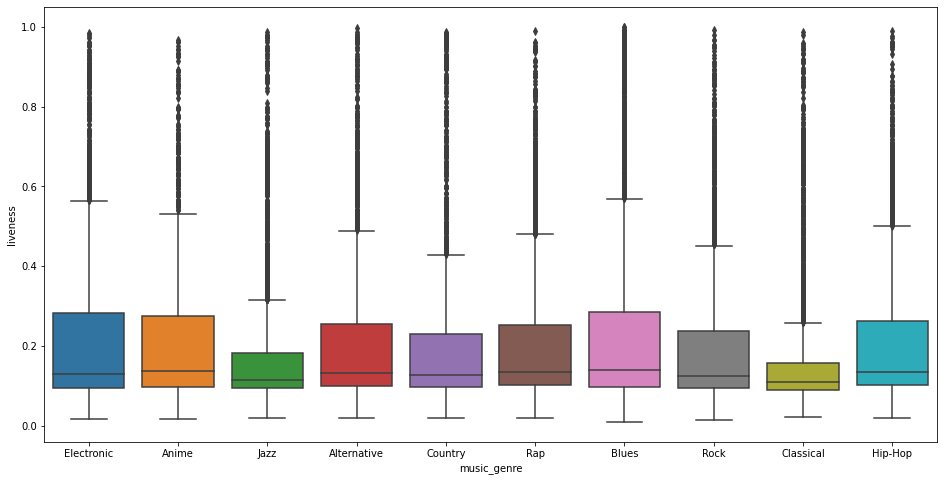

In [54]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='liveness')
plt.show()

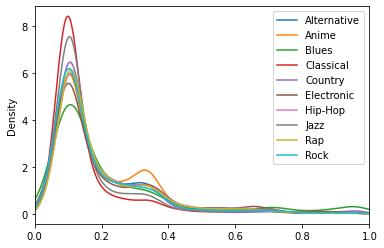

In [55]:
data.groupby('music_genre')['liveness'].plot.kde()
plt.legend()
plt.xlim([0,1])
plt.show()

#### The distributions seem similarly skewed for all genres, so this feature will likely not contribute much to the model. We'll try both with and without this feature.

## Loudness:

In [56]:
data.groupby('music_genre')['loudness'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,-6.517714,2.767036,-22.191,-7.98250,-5.9930,-4.50000,1.342
Anime,5000.0,-7.963515,6.246825,-41.234,-10.69125,-5.6605,-3.58900,1.893
Blues,5000.0,-9.009528,3.833429,-31.284,-11.31600,-8.4555,-6.17675,3.744
Classical,5000.0,-21.586253,7.730315,-47.046,-26.44300,-21.8725,-17.23300,-2.304
Country,5000.0,-7.297150,3.210097,-27.119,-8.80225,-6.5275,-5.02000,-0.521
Electronic,5000.0,-7.034238,3.683159,-25.582,-9.26050,-6.4650,-4.37600,1.585
Hip-Hop,5000.0,-6.851158,2.457706,-25.602,-8.16025,-6.5090,-5.20350,1.012
Jazz,5000.0,-11.185364,4.662576,-35.200,-13.62125,-10.3455,-7.84350,-1.002
Rap,5000.0,-6.668337,2.427193,-22.589,-7.97650,-6.3550,-5.03775,-0.092


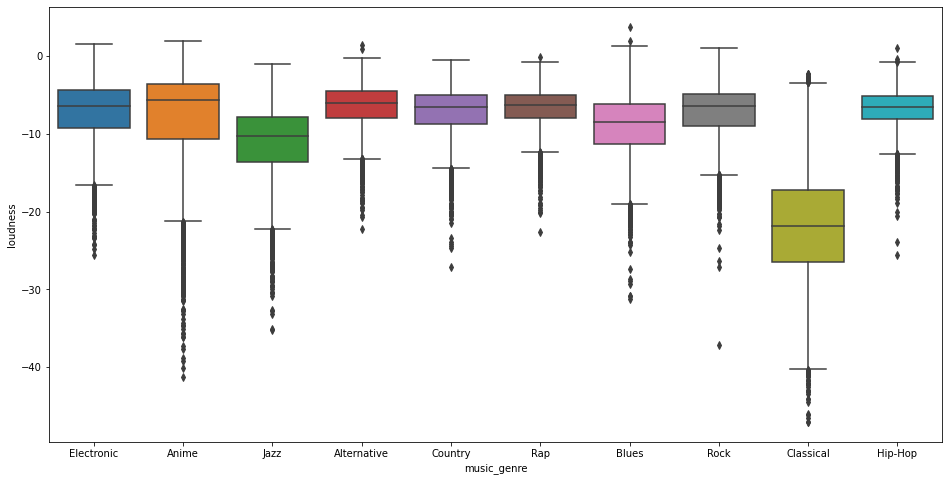

In [57]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='loudness')
plt.show()

#### As usual, classical music is far from the rest, with Jazz (and Blues) also differing from the rest somewhat.

## Mode:

In [58]:
data['mode'].unique()

array(['Minor', 'Major'], dtype=object)

In [59]:
data.groupby('music_genre')['mode'].describe()

,count,unique,top,freq
music_genre,,,,
Alternative,5000,2,Major,3167
Anime,5000,2,Major,3101
Blues,5000,2,Major,3563
Classical,5000,2,Major,3328
Country,5000,2,Major,4362
Electronic,5000,2,Major,2692
Hip-Hop,5000,2,Major,2777
Jazz,5000,2,Major,2648
Rap,5000,2,Major,2763


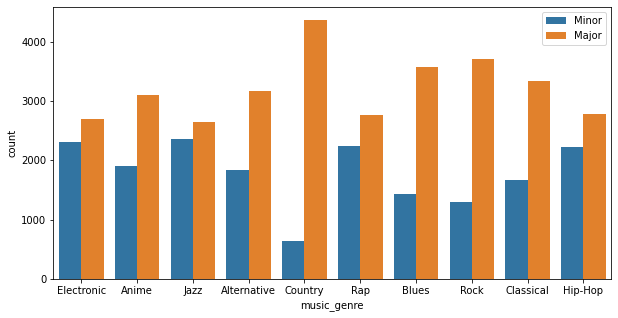

In [60]:
plt.figure(figsize=(10,5))
sns.countplot(x="music_genre", hue="mode",data=data)
plt.legend(loc=0)
plt.show()

#### All genres seem to have a prefererence for the "Major" mode, but to different degrees. It is the most pronounced in the Country genre. We'll use this feature after one hot encoding.

In [61]:
# One Hot Encoding
data = pd.get_dummies(data, drop_first=True, columns=['mode'])

## Speechiness:

In [62]:
data.groupby('music_genre')['speechiness'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.088819,0.092578,0.0231,0.035900,0.0519,0.0969,0.941
Anime,5000.0,0.064608,0.052907,0.0229,0.034800,0.0452,0.0708,0.498
Blues,5000.0,0.062157,0.062483,0.0231,0.033875,0.0431,0.0650,0.942
Classical,5000.0,0.051575,0.037965,0.0239,0.038400,0.0433,0.0506,0.631
Country,5000.0,0.049032,0.048846,0.0223,0.029500,0.0346,0.0456,0.689
Electronic,5000.0,0.098891,0.098593,0.0234,0.040100,0.0575,0.1110,0.774
Hip-Hop,5000.0,0.207044,0.136928,0.0246,0.085450,0.1920,0.2990,0.932
Jazz,5000.0,0.073629,0.081572,0.0226,0.035300,0.0438,0.0676,0.939
Rap,5000.0,0.186707,0.132777,0.0229,0.070100,0.1585,0.2800,0.922


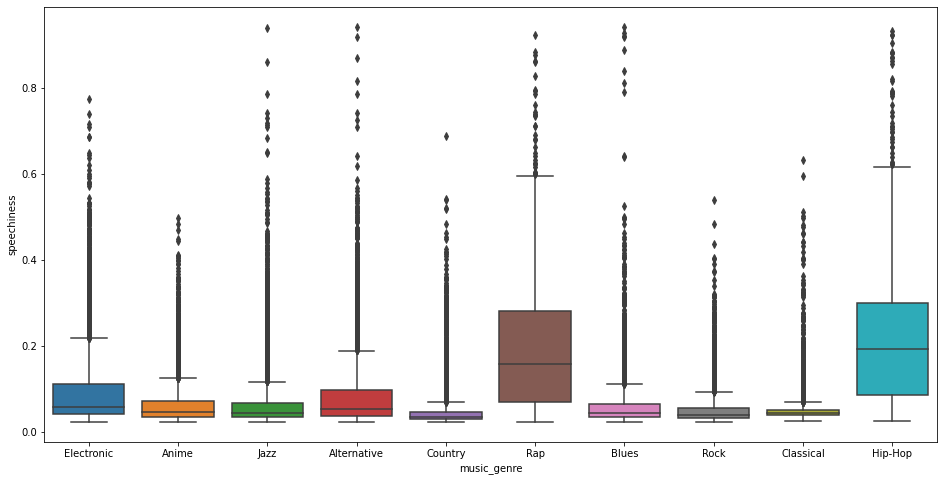

In [63]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='speechiness')
plt.show()

#### This feature should contribute especially to identifying Hip-Hop and Rap.

## Tempo:

In [64]:
data.groupby('music_genre')['tempo'].describe()

,count,unique,top,freq
music_genre,,,,
Alternative,5000,4236,?,505
Anime,5000,4134,?,503
Blues,5000,4376,?,530
Classical,5000,4380,?,500
Country,5000,4233,?,514
Electronic,5000,3644,?,534
Hip-Hop,5000,4115,?,480
Jazz,5000,4302,?,479
Rap,5000,4076,?,496


#### This feature should be numeric. The "?" is a missing value.

In [65]:
print(f"This feature contains {(data[data['tempo'] == '?'].shape[0]/data.shape[0])*100:2.4}% missing values")

This feature contains 9.96% missing values


In [66]:
# replace "?" with np.nan and correctly classify the feature:
data.loc[data['tempo'] == '?', 'tempo'] = np.nan
data = data.astype({'tempo': np.float64})

In [67]:
data.groupby('music_genre')['tempo'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,4495.0,122.547235,30.222638,44.194,96.98500,120.0530,143.99300,213.788
Anime,4497.0,126.799978,33.063462,47.704,98.96000,127.9720,149.98900,220.276
Blues,4470.0,121.379962,30.326710,47.587,97.64475,118.3720,141.22525,215.918
Classical,4500.0,104.053190,30.944454,34.347,79.23325,96.5515,127.30200,212.923
Country,4486.0,123.784286,30.082410,55.513,99.75675,123.0420,144.67175,217.538
Electronic,4466.0,125.930571,26.482007,35.551,107.83275,125.9830,144.97300,220.041
Hip-Hop,4520.0,120.154134,29.882185,47.092,93.99425,120.2070,141.04025,213.788
Jazz,4521.0,111.699415,29.648000,34.765,90.00300,104.8380,127.99800,213.038
Rap,4504.0,120.585501,29.279738,47.811,95.00900,120.8195,140.74450,207.986


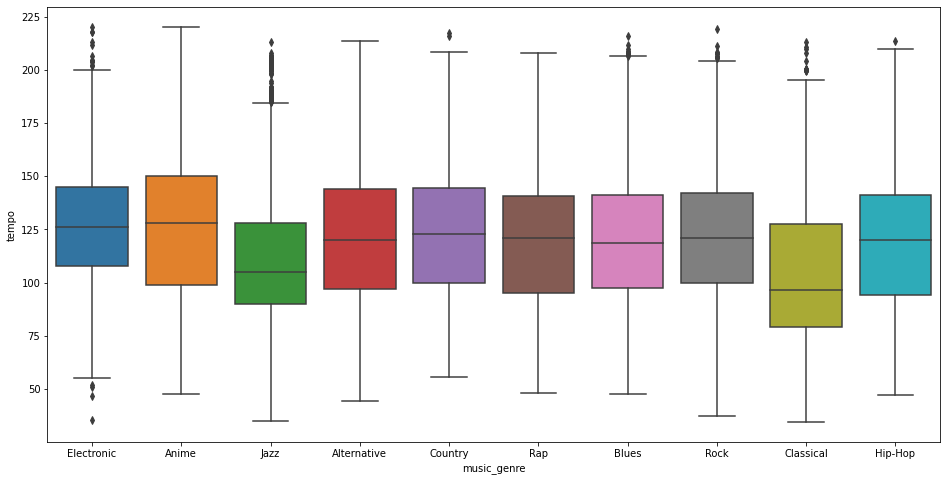

In [68]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='tempo')
plt.show()

#### The variation between genres is not great. We'll fill missing values with the median, but consider dropping the feature altogether in the future.

In [69]:
median_tempo = data['tempo'].median()
data['tempo'] = data['tempo'].fillna(median_tempo)

## Obtained date:

In [70]:
data['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr', '0/4'], dtype=object)

In [71]:
data.groupby('music_genre')['obtained_date'].describe()

,count,unique,top,freq
music_genre,,,,
Alternative,5000,4,4-Apr,4608
Anime,5000,4,4-Apr,4410
Blues,5000,4,4-Apr,4359
Classical,5000,4,4-Apr,3329
Country,5000,4,4-Apr,4679
Electronic,5000,4,4-Apr,4789
Hip-Hop,5000,4,4-Apr,4740
Jazz,5000,4,4-Apr,4340
Rap,5000,5,4-Apr,4759


#### Only gives the 4 dates at which the data was obtained. Not useful to us, so we'll drop it.

In [72]:
data = data.drop(columns=['obtained_date'])

## Valence:

In [73]:
data.groupby('music_genre')['valence'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,5000.0,0.447513,0.216445,0.0342,0.28300,0.4285,0.60000,0.983
Anime,5000.0,0.437670,0.248353,0.0000,0.23200,0.4390,0.63200,0.990
Blues,5000.0,0.580788,0.224741,0.0315,0.41000,0.5900,0.76000,0.985
Classical,5000.0,0.210523,0.197650,0.0000,0.05650,0.1400,0.30525,0.982
Country,5000.0,0.536732,0.221114,0.0396,0.36100,0.5270,0.71625,0.977
Electronic,5000.0,0.389884,0.239673,0.0205,0.18900,0.3585,0.55900,0.992
Hip-Hop,5000.0,0.474927,0.220622,0.0336,0.30300,0.4735,0.64300,0.979
Jazz,5000.0,0.509248,0.251076,0.0289,0.29675,0.5150,0.71100,0.985
Rap,5000.0,0.454999,0.213480,0.0336,0.28900,0.4460,0.61200,0.970


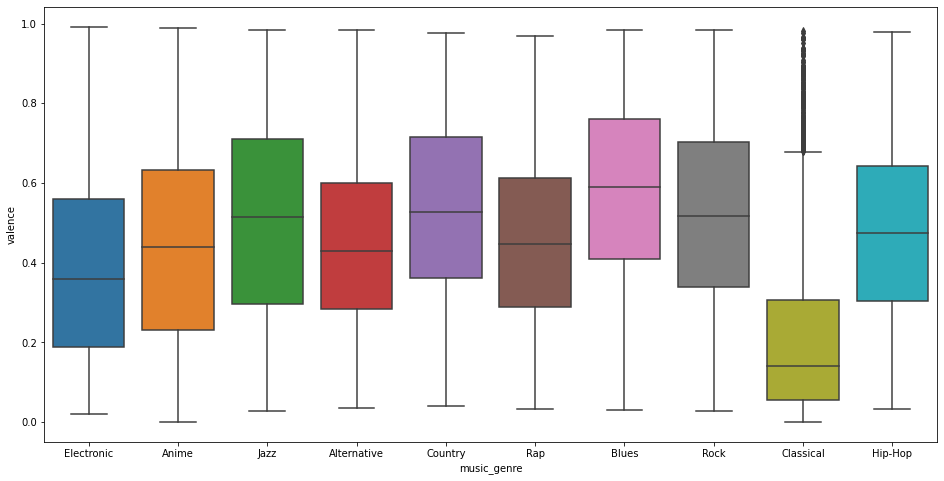

In [74]:
plt.figure(figsize=(16,8))
sns.boxplot(data=data, x='music_genre', y='valence')
plt.show()

#### Again, only classical music truly stands out from the rest.

## EDA Summary:

### Labels:
There are 10 equally likely musical genres (balanced dataset): 
1. Alternative 
2. Anime
3. Blues
4. Classical
5. Country
6. Electronic
7. Hip-Hop
8. Jazz
9. Rap
10. Rock

### Features:

**Useful features:**
1. popularity - left as is.
2. acousticness - left as is.
3. danceability - left as is.
4. duration_ms - 10% of the entries had missing values, they were filled in with the median.
5. energy - left as is.
6. key - a categorical column containing 12 unique categories. One hot encoding was used.
7. liveness - left as is with a caveat: may be removed later on due to a lack of variance between genres.
8. loudness - left as is.
9. mode - a categorical column containing only 2 unique categories. One hot encoding was used.
10. speechiness - left as is.
11. tempo - contained 10% missing values and missclassified as catagorical. The missing values were filled in with the median and the feature was correctly classified as numerical. Caveat: contains very similar distributions between the genres. might be removed later on.           
12. valence - left as is.

**Unhelpful Features that where removed:**
1. instance_id - only an index.
2. obtained_date - only contains the 4 consecutive dates of data aquisition.
3. instrumentalness - contains 30% missing values.
4. artist_name and track_name - were used to obtain new features (see below) and then discarded.

**New features:**
1. length_track_name - the track_name feature has essentially been converted to the length of the name. This feature helps identify the classic genre.
2. Japanese - This feature indicates wether the track/artist name is written in Japanese. This helps identify the Anime genre.

**General observations:** 

It would appear that most genres tend to have very similar distributions in most features, making it hard for any model to distinguish between them. The obviouse exception is classical music, which has very different distributions in many features.
The Anime genre also shows some distinguishing characteristics, as well as Jazz, to a much lesser extent. Hip-Hop and Rap are extremely similar to one another in all features, but are separate from the rest of the genres in some features. They might be easier to identify as one joint genre.
All in all, The current features are unlikely to give great predictions for all genres. We'll find out if this is true soon enough.

# 2. Final Preprocessing

## Separate features from labels and encode labels:

In [75]:
data['music_genre'] = data['music_genre'].astype('category')
y = data['music_genre'].cat.codes
y_names = list(data['music_genre'].cat.categories)

X = data.drop(columns=['music_genre'])

## Normalize our new features:

In [76]:
scaler = RobustScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [77]:
X_scaled.describe()

,popularity,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,-0.035435,0.305231,-0.039833,0.221751,-0.113207,0.461567,-3.265801e-01,0.715843,0.001560,0.021137,...,0.110440,0.10810,0.105300,0.031800,0.075200,0.086820,0.062020,0.114540,0.066380,0.358020
std,0.706455,0.641617,0.729110,1.436517,0.692564,1.098824,1.083698e+00,1.623920,0.681049,0.632017,...,0.313441,0.31051,0.306943,0.175469,0.263716,0.281574,0.241194,0.318469,0.248948,0.479423
min,-2.045455,-0.270677,-2.075102,-2.873053,-1.681173,-0.790823,-6.993054e+00,-0.426111,-2.003443,-1.145780,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.500000,-0.233083,-0.514286,-0.440551,-0.549738,-0.197825,-6.301213e-01,-0.205046,-0.541155,-0.488491,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.808966e-17,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.766917,0.485714,0.559449,0.450262,0.802175,3.698787e-01,0.794954,0.458845,0.511509,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.454545,1.601504,1.706122,62.427687,0.931937,5.941536,1.937841e+00,14.306768,2.351631,1.391304,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Outlier Removal:

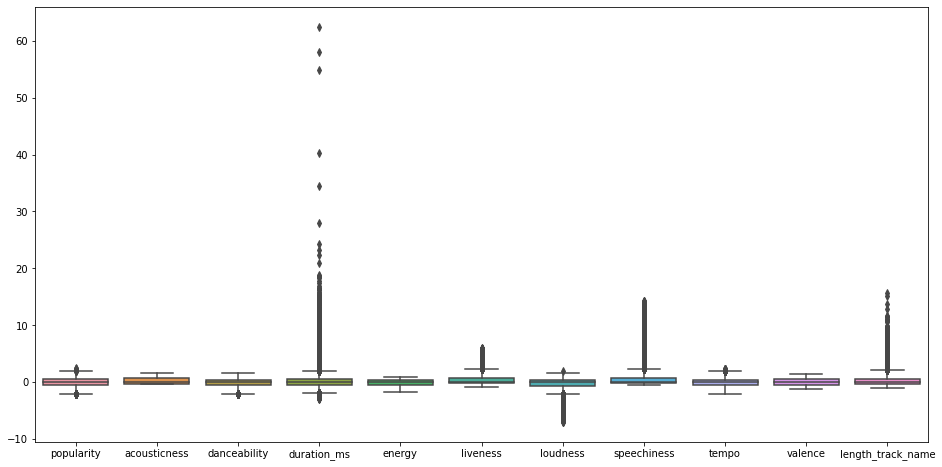

In [78]:
numerical_feats = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
                   'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'length_track_name']

plt.figure(figsize=(16,8))
sns.boxplot(data=X_scaled[numerical_feats])
plt.show()

#### As can be clearly seen, some features, especially the duration feature, contain extreme ouliers. These outliers can hinder the success of all models, so we'll remove them.

In [79]:
X_no_outliers = X_scaled[(np.abs(zscore(X_scaled[numerical_feats])) < 4).all(axis=1)]
y_no_outliers = y[X_no_outliers.index]

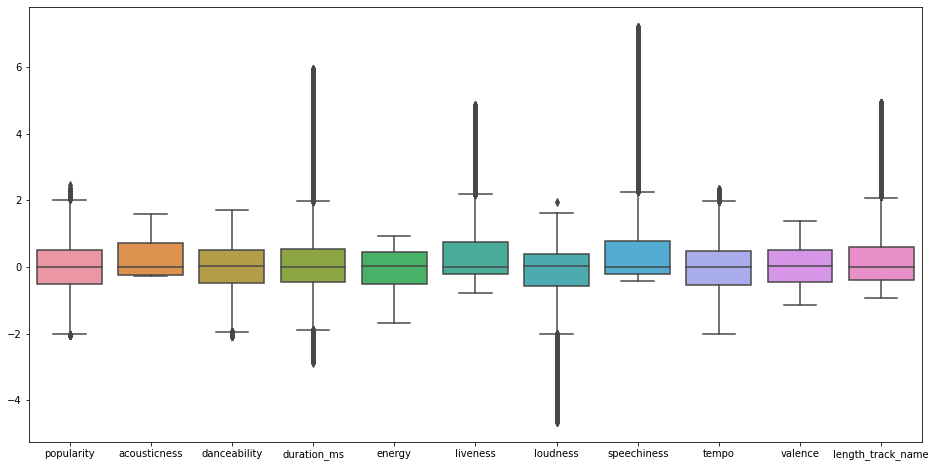

In [80]:
plt.figure(figsize=(16,8))
sns.boxplot(data=X_no_outliers[numerical_feats])
plt.show()

(Note: Some of the features are clearly skewed. However, using log/boxcox on them did not improve the final results, and so it is ommitted here)

## Check correlation and reduce dimensionality with PCA:

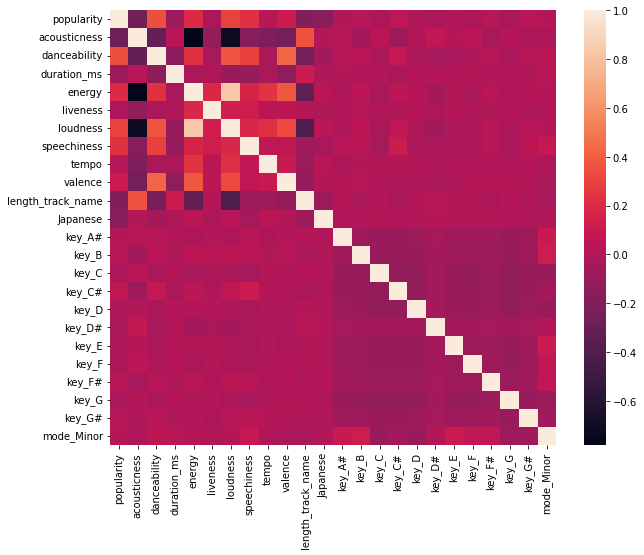

In [81]:
plt.figure(figsize=(10,8))
sns.heatmap(X_no_outliers.corr(), annot=False)
plt.show()

#### Let's zoom in on the upper left corner where there are some noticeable correlations:

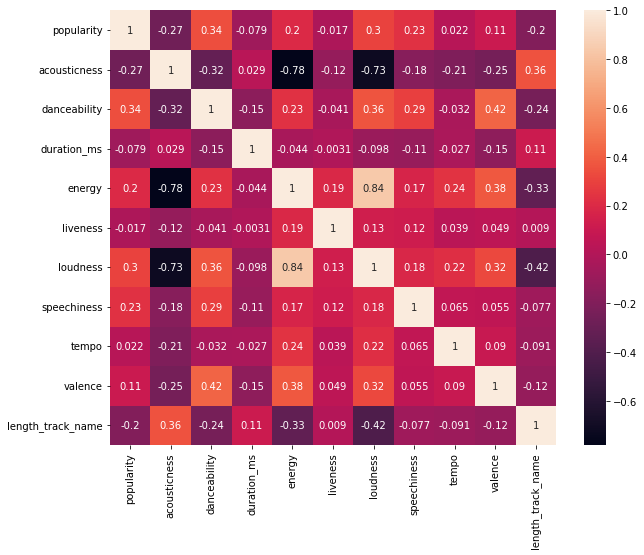

In [82]:
plt.figure(figsize=(10,8))
sns.heatmap(X_no_outliers.iloc[:,:11].corr(), annot=True)
plt.show()

#### Loudness, Acousticness and energy are highly correlated. PCA will address this while also reducing the dimesionality of our data set.

In [83]:
pca = PCA().fit(X_no_outliers)

# find the first n components that account for 95% of the variance 
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
n_components = (cum_exp_var <= 0.95).sum()

X_pca = pca.transform(X_no_outliers)[:,:n_components]

## Split the data to train and test:

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, y_no_outliers, test_size=0.3)

## Final Preprocessing Summary

1. The features and labels (music genres) were separated and the **labels were encoded**.
2. The features were **normalized** using RobustScaler.
3. Extreme **outliers were removed** based on z-score.
4. PCA was used for **dimensionality reduction**.
5. The dataset was **devided to train and test sets**.

# 3. Modeling:

We will test 3 basic, unoptimized models to see how well they do with our data set.

In [85]:
def get_metrics(model, X, y, y_names):
    clf = model

    X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.3)

    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_valid = clf.predict(X_valid)

    print(f"Train accuracy score: {accuracy_score(y_train, predict_train)*100:2.4}%")
    print(f"Validation accuracy score: {accuracy_score(y_valid, predict_valid)*100:2.4}%\n")

    print('Classification Report for the validation set:\n')
    print(classification_report(y_valid, predict_valid, target_names=y_names))
    print('Confusion Matrix:\n')
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_valid, predict_valid), annot = True, fmt = ".0f", 
                cmap = "coolwarm", linewidths = 1, linecolor = "white",
                xticklabels = y_names, yticklabels = y_names)
    plt.show()

## SVC:

Train accuracy score: 59.22%
Validation accuracy score: 54.75%

Classification Report for the validation set:

              precision    recall  f1-score   support

 Alternative       0.41      0.36      0.38      1038
       Anime       0.75      0.72      0.73      1006
       Blues       0.57      0.46      0.51      1043
   Classical       0.85      0.83      0.84       839
     Country       0.52      0.52      0.52      1054
  Electronic       0.57      0.59      0.58      1006
     Hip-Hop       0.43      0.57      0.49      1013
        Jazz       0.50      0.50      0.50      1018
         Rap       0.45      0.32      0.38      1049
        Rock       0.51      0.67      0.58      1045

    accuracy                           0.55     10111
   macro avg       0.56      0.55      0.55     10111
weighted avg       0.55      0.55      0.54     10111

Confusion Matrix:



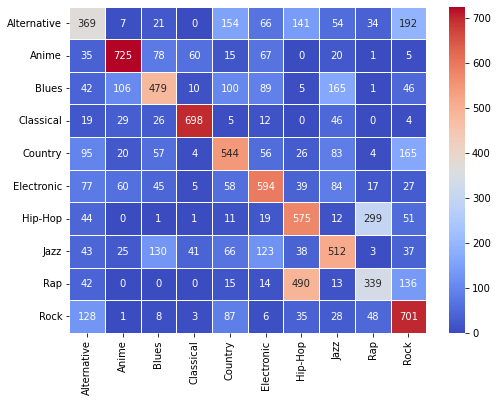

In [86]:
get_metrics(SVC(), x_train, y_train, y_names)

## KNN:

Train accuracy score: 62.12%
Validation accuracy score: 44.48%

Classification Report for the validation set:

              precision    recall  f1-score   support

 Alternative       0.27      0.36      0.31      1080
       Anime       0.66      0.65      0.65      1029
       Blues       0.38      0.39      0.39       963
   Classical       0.80      0.80      0.80       879
     Country       0.39      0.48      0.43      1039
  Electronic       0.50      0.39      0.44      1042
     Hip-Hop       0.39      0.43      0.41      1023
        Jazz       0.44      0.36      0.39      1011
         Rap       0.35      0.30      0.32      1005
        Rock       0.42      0.34      0.38      1040

    accuracy                           0.44     10111
   macro avg       0.46      0.45      0.45     10111
weighted avg       0.45      0.44      0.45     10111

Confusion Matrix:



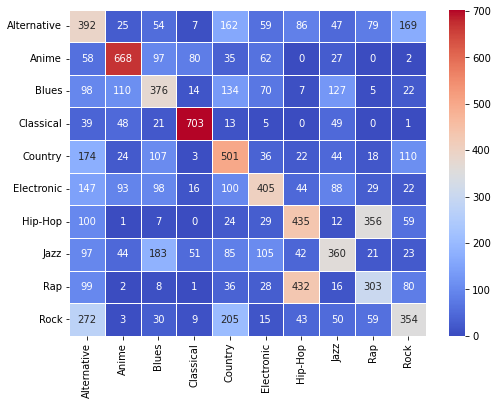

In [87]:
get_metrics(KNeighborsClassifier(), x_train, y_train, y_names)

## Random Forest:

Train accuracy score: 98.33%
Validation accuracy score: 49.1%

Classification Report for the validation set:

              precision    recall  f1-score   support

 Alternative       0.33      0.31      0.32      1034
       Anime       0.65      0.73      0.69       967
       Blues       0.50      0.40      0.45      1020
   Classical       0.83      0.79      0.81       857
     Country       0.47      0.45      0.46      1058
  Electronic       0.56      0.54      0.55      1032
     Hip-Hop       0.37      0.41      0.39      1030
        Jazz       0.45      0.43      0.44      1044
         Rap       0.35      0.34      0.34      1020
        Rock       0.46      0.57      0.51      1049

    accuracy                           0.49     10111
   macro avg       0.50      0.50      0.50     10111
weighted avg       0.49      0.49      0.49     10111

Confusion Matrix:



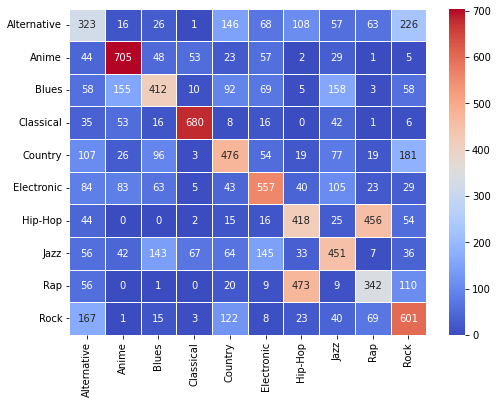

In [88]:
get_metrics(RandomForestClassifier(), x_train, y_train, y_names)

*Note the obviouse overfitting appearant in this case (and in KNN to a lesser degree).

#### It would appear that all of the models we tried were almost equaly as ineffective (~40-50% accuracy), but SVC does better than the rest and mostly avoids overfitting.
#### Before we'll analyze further, we'll do a short sanity check and see if this is related to the use of PCA, outlier removal, or if it has to do with the features that we engineered/filled missing values in.

## Try with less fetures, without PCA, and keeping the outliers in:

Train accuracy score: 57.27%
Validation accuracy score: 54.15%

Classification Report for the validation set:

              precision    recall  f1-score   support

 Alternative       0.41      0.35      0.38      1039
       Anime       0.71      0.65      0.68      1089
       Blues       0.53      0.47      0.50      1029
   Classical       0.80      0.83      0.81      1069
     Country       0.51      0.48      0.49      1045
  Electronic       0.60      0.56      0.58      1044
     Hip-Hop       0.45      0.60      0.51      1091
        Jazz       0.47      0.45      0.46      1027
         Rap       0.41      0.29      0.34      1024
        Rock       0.50      0.72      0.59      1043

    accuracy                           0.54     10500
   macro avg       0.54      0.54      0.53     10500
weighted avg       0.54      0.54      0.54     10500

Confusion Matrix:



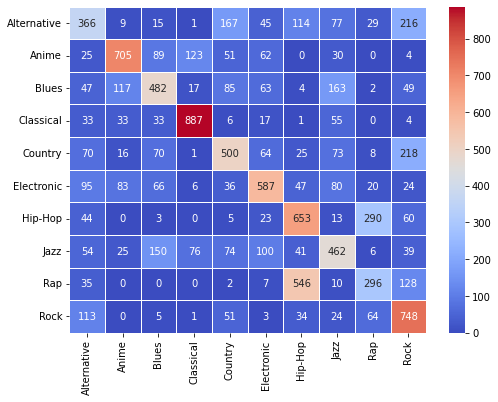

In [89]:
X_reduced = X_scaled.drop(['duration_ms', 'liveness', 'tempo', 'length_track_name', 'Japanese'], axis=1)
x_train_check, x_test_check, y_train_check, y_test_check = train_test_split(X_reduced, y, test_size=0.3)

get_metrics(SVC(), x_train_check, y_train_check, y_names)


#### This had no effect on the poor performance.
#### It's not shown here for brevity, but removing all samples with missing values (instead of a whole feature) also did nothing to improve the results.

## Modeling Summary:

SVM, KNN, and Random Forest models were used on the data set, but all yielded bad results (40-50% accuracy). SVM was the best out of a bad bunch. 

Possible effects of outliers, dimensionality reduction and missing values were tested and discarded.

The next section will analyze the results in more depth and propose a solution.

# 4. Consolidating classes

An important thing to note is that as we hypothesized from the EDA, one genre, classical music, has much higher precision/recall scores than all the rest. This is also true to a lesser extent regarding the Anime genre.

Meanwhile, Hip-Hop and Rap seem to be interchangeable and can't be distinguished from one another, but they are relatively well separated from the rest of the genres (as evidenced by the confusion matrix).

Rock, Alternative and maybe Country also seem to have some similarity resulting in missclassification. Same goes for Blues and Jazz and maybe Electronic. These combinations are much more tentative, though.

#### **Proposed solution:** combine similar genres into one, while keeping the classical genre (and perhaps Anime) separate.

Train accuracy score: 87.17%
Validation accuracy score: 85.96%

Classification Report for the validation set:

                 precision    recall  f1-score   support

            All       0.88      0.92      0.90      6267
          Anime       0.79      0.66      0.72       983
      Classical       0.86      0.78      0.82       844
Rap and Hip-Hop       0.83      0.80      0.82      2017

       accuracy                           0.86     10111
      macro avg       0.84      0.79      0.81     10111
   weighted avg       0.86      0.86      0.86     10111

Confusion Matrix:



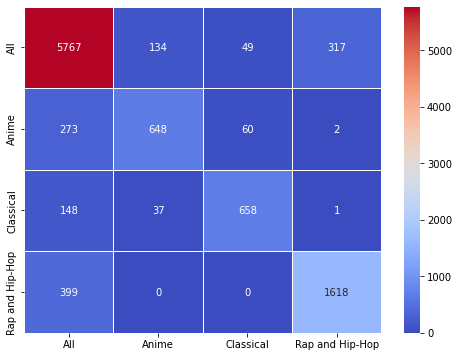

In [90]:
# 1 - Anime, 2 - Classical, 3 - Rap and Hip-Hop, 0 - all the rest
y_train_combined_1 = y_train.map({0:0, 1:1, 2:0, 3:2, 4:0, 5:0, 6:3, 7:0, 8:3, 9:0})
y_names_comb_1 = ['All', 'Anime', 'Classical', 'Rap and Hip-Hop']
get_metrics(SVC(), x_train, y_train_combined_1, y_names_comb_1)

*Note that the data is now imbalanced, so we focus on the precision/recall/f1-score and not the accuracy.

#### It would appear that putting Hip-Hop and Rap together greatly improves their result, putting the joint genre on par with classical music when it comes to precision/recall. 

#### The next step is to try to separate out the other genres into smaller groups according to the missclassification seen in the confusion matrices in section 3.

Train accuracy score: 79.17%
Validation accuracy score: 77.06%

Classification Report for the validation set:

                               precision    recall  f1-score   support

Rock, Alternative and Country       0.73      0.79      0.76      3143
                        Anime       0.80      0.67      0.73      1050
                    Classical       0.87      0.78      0.82       843
              Rap and Hip-Hop       0.82      0.83      0.83      2061
   Jazz, Blues and Electronic       0.75      0.75      0.75      3014

                     accuracy                           0.77     10111
                    macro avg       0.79      0.76      0.78     10111
                 weighted avg       0.77      0.77      0.77     10111

Confusion Matrix:



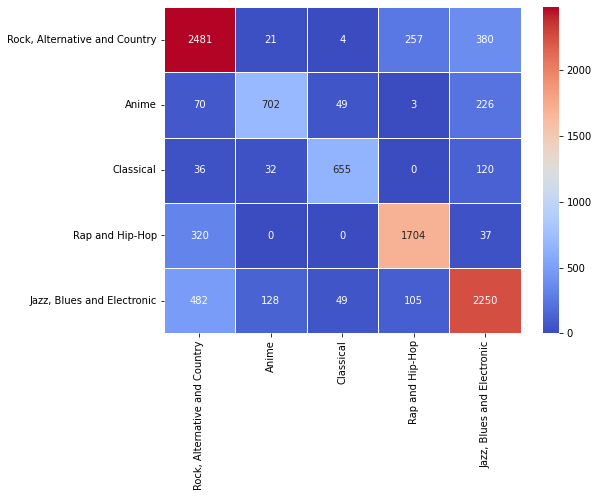

In [91]:
# 0 - Rock, Alternative and country, 1 - Anime, 2 - Classical, 3 - Rap and Hip-Hop, 4 - Jazz, Blues and Electronic 
y_train_combined_2 = y_train.map({0:0, 1:1, 2:4, 3:2, 4:0, 5:4, 6:3, 7:4, 8:3, 9:0})
y_names_comb_2 = ['Rock, Alternative and Country', 'Anime', 'Classical', 'Rap and Hip-Hop', 'Jazz, Blues and Electronic']
get_metrics(SVC(), x_train, y_train_combined_2, y_names_comb_2)

#### We grouped the Elecrtronic genre with Jazz and Blues, and the Country genre with Rock and Alternative. These are not intuitive combinations, but the missclassification seen in the confusion matrices seems to hint at this.
#### The f1-scores for these groupings are on par and better than that of the Anime genre, so this appears to be a good choice.

## Class Consolidation Summary:
It would appear that our best course of action is to rearange the data into 5 separate categories: Classical music, Anime, Hip-Hop and Rap (together), Jazz, Blues and Electronic (together), and Rock, Alternative and Country (together). This will give us relatively good recall/precision results for these genres, especially Classical and Rap/Hip-Hop.

We might not be able to identify everything perfectly down to the exact genre, but at least we're able to narrow the options significantly!
To identify the rest, more feature engineering (additional data) is required.

# 5. Final Test results

Classification Report for the test set:

                               precision    recall  f1-score   support

Rock, Alternative and Country       0.79      0.74      0.76      4730
                        Anime       0.71      0.80      0.76      1379
                    Classical       0.78      0.88      0.83      1104
              Rap and Hip-Hop       0.85      0.82      0.83      3017
   Jazz, Blues and Electronic       0.74      0.76      0.75      4214

                     accuracy                           0.78     14444
                    macro avg       0.77      0.80      0.79     14444
                 weighted avg       0.78      0.78      0.78     14444

Confusion Matrix:



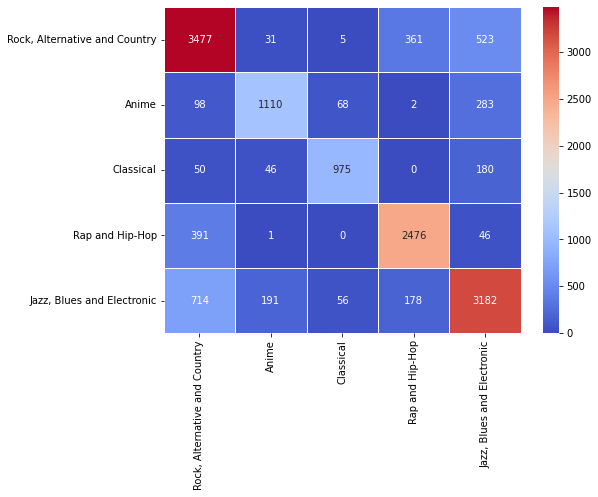

In [92]:
final_mod = SVC().fit(x_train, y_train_combined_2)
predictions = final_mod.predict(x_test)

y_test_combined = y_test.map({0:0, 1:1, 2:4, 3:2, 4:0, 5:4, 6:3, 7:4, 8:3, 9:0})

print('Classification Report for the test set:\n')
print(classification_report(predictions, y_test_combined, target_names=y_names_comb_2))
print('Confusion Matrix:\n')
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_combined, predictions), annot = True, fmt = ".0f", 
            cmap = "coolwarm", linewidths = 1, linecolor = "white",
            xticklabels = y_names_comb_2, yticklabels = y_names_comb_2)
plt.show()